C:\Anaconda\lib\site-packages\matplotlib\contour.py:967: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


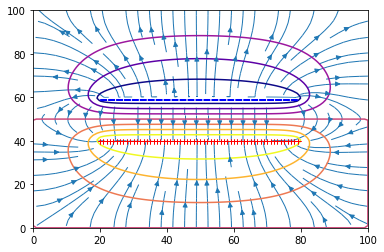

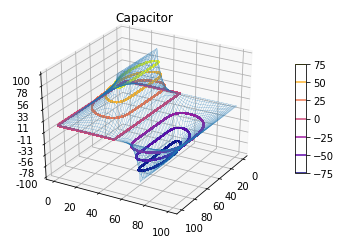

In [47]:
# -*- coding: utf-8 -*-

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import lines as line
from matplotlib.lines import Line2D

class solution:
    def __init__(self, Nx, Ny,U0, eps, cut, omega): #cut is the number of terms in the analytical formula,
# omega is parameter of relaxation
        self.err = eps
        self.X = Nx
        self.Y = Ny
        self.init = np.zeros((Nx, Ny))
        self.cut = cut        
        self.w = omega
        self.u0 = U0
        
    def Analitic(self):
        x = np.linspace(0, self.X, self.X)
        y = np.linspace(0, self.Y, self.Y)
        xgrid, ygrid = np.meshgrid(x, y)
        x = xgrid
        y = ygrid
        U = 0
        for n in range(self.cut):
            U += 4*self.u0/(np.pi*(2*n+1))*( np.cosh(x*(2*n+1)*np.pi/self.X)-1/np.tanh((2*n+1)*np.pi)*np.sinh(x*(2*n+1)*np.pi/self.X) )* np.sin(y*(2*n+1)*np.pi/self.Y) 
        return U
    
    def Jacobi(self):
        self.U = self.init
        self.U[:, 0] = self.u0
        self.U[self.X-1, 1:] = 0
        self.U[0, 1:] = 0
        self.U[:, self.Y-1] = 0       
        for i in range(5000):
            self.init = self.U
            self.U[1:self.X-1, 1:self.Y-1] = (self.init[0:-2, 1:-1]+self.init[2:, 1:-1]+self.init[1:-1, 2:]+self.init[1:-1, 0:-2])/4
        return self.U
    
    def Gauss_Seidel(self):
        self.U = self.init
        self.U[:, 0] = self.u0
        self.U[self.X-1, 1:] = 0
        self.U[0, 1:] = 0
        self.U[:, self.Y-1] = 0
        delta = 1
        while (delta > self.err):
            Sp1 = np.trace(self.U)
            self.U[1:self.X-1, 1:self.Y-1] = (self.U[0:-2, 1:-1]+self.U[2:, 1:-1]+self.U[1:-1, 2:]+self.U[1:-1, 0:-2])/4 
            Sp2 = np.trace(self.U)
            delta = np.absolute(np.absolute(Sp1)-np.absolute(Sp2))
        return self.U
    
    def Relaxation(self):
        R = np.zeros((self.X-2, self.Y-2))
        self.U = self.init
        self.U[:, 0] = self.u0
        self.U[self.X-1, 1:] = 0
        self.U[0, 1:] = 0
        self.U[:, self.Y-1] = 0
        delta = 1
        while (delta > self.err):
            Sp1 = np.trace(self.U)
            R = (self.U[0:-2, 1:-1]+self.U[2:, 1:-1]+self.U[1:-1, 2:]+self.U[1:-1, 0:-2])/4 - self.U[1:self.X-1, 1:self.Y-1]
            self.U[1:self.X-1,1:self.Y-1] += self.w*R
            Sp2 = np.trace(self.U)
            delta = np.absolute(np.absolute(Sp1)-np.absolute(Sp2))
        return self.U
    
    def Capacitor(self):
        self.U = np.loadtxt('capacitor.txt')
        X = self.U.shape[0]
        Y = self.U.shape[1]
        U_buf = np.zeros((X, Y))
        np.copyto(U_buf, self.U)
        x = np.nonzero(U_buf)[0]
        y = np.nonzero(U_buf)[1]
        x = np.unique(x)
        for i in range(10000):
            self.U[1:X-1, 1:Y-1] = (self.U[0:-2, 1:-1]+self.U[2:, 1:-1]+self.U[1:-1, 2:]+self.U[1:-1, 0:-2])/4
            self.U[x[0], y[0]:y[len(y)-1]] = self.u0
            self.U[x[1], y[0]:y[len(y)-1]] = -self.u0
#create lines of electric field
        x1 = np.full(len(y), x[0])
        x2 = np.full(len(y), x[1])
        xx = np.linspace(0, X, X)
        yy = np.linspace(0, Y, Y)
        xx, yy = np.meshgrid(xx, yy)
        self.E_x = (self.U[1:-1, 2:]-self.U[1:-1, 0:-2])/2
        self.E_y = (self.U[2:, 1:-1]-self.U[0:-2, 1:-1])/2
        self.E_x = np.insert(self.E_x, 0, 0, axis=0)
        self.E_x = np.insert(self.E_x, X - 1, 0, axis=0)
        self.E_x = np.insert(self.E_x, 0, 0, axis=1)
        self.E_x = np.insert(self.E_x, Y - 1, 0, axis=1)
        self.E_y = np.insert(self.E_y, 0, 0, axis=0)
        self.E_y = np.insert(self.E_y, X - 1, 0, axis=0)
        self.E_y = np.insert(self.E_y, 0, 0, axis=1)
        self.E_y = np.insert(self.E_y, Y - 1, 0, axis=1)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.streamplot(xx, yy, self.E_x, self.E_y, linewidth=1)
        plt.contour(xx, yy, self.U, cmap=cm.plasma, linewidth=1)
        plt.plot(y, x1, '+', color='red', ms=5)
        plt.plot(y, x2, '--', color='blue', ms=5)
        plt.show()

        return self.U
    
    def plotter(self, U, method):
        x = np.linspace(0, self.X, self.X)
        y = np.linspace(0, self.Y, self.Y)
        self.xgrid, self.ygrid = np.meshgrid(x, y)
        
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        face = plt.contour(self.xgrid, self.ygrid, U, cmap=cm.plasma, linewidth=0, antialiased=False)
        ax.plot_wireframe(self.xgrid, self.ygrid, U, cmap=cm.plasma, linewidth=0.2)        
        if method == 'Capacitor':
            ax.set_zlim(-100, 100)
        else:
            ax.set_zlim(0, 100)
        ax.zaxis.set_major_locator(LinearLocator(10))
        ax.zaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        fig.colorbar(face, shrink=0.5, aspect=10)
        ax.set_title(method)
        ax.view_init(30, 30)
        plt.show()
        
    def run(self, method):
        if method == 'Jacobi':
            self.plotter(self.Jacobi(), 'Jacobi')
        elif method == 'Fourier':
            self.plotter(self.Fourier(), 'Fourier')
        elif method == 'Gauss-Seidel':
            self.plotter(self.Gauss_Seidel(), 'Gauss-Seidel')
        elif method == 'Relaxation':
            self.plotter(self.Relaxation(), 'Relaxation')
        elif method == 'Capacitor':
            self.plotter(self.Capacitor(), 'Capacitor')
    
test = solution(100, 100,100, 0.001, 100, 1.005)
test.run("Capacitor")